In [13]:
from tqdm import tqdm
import random as rand
import numpy as np
import time
import copy

# Plotting Packages
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [14]:
class MDP_Environment():
    def __init__(self, rewards = None):
        # Creating an array for storing the rewards
        if rewards == None:
            self.rewards = [
                [+1, -10, -10, -10],
                [-1, -1, -1, -1],
                [-10, -10, -10, -1],
                [-1, -1, -1, -1],
            ]
        else:
            self.rewards = rewards

        # Definining the Initial State Value function
        self.S = np.zeros((4, 4))

        # Definining the Initial Equi-probable Random policy
        # The first 2 indices represents the state
        # The third index represents the action in any particular state
        self.pi = np.ones((4, 4, 4)) * 0.25

        # DEBUG CODE | IGNORE
        # self.S = np.arange(16).reshape((4, 4))
        # self.pi = np.zeros((4, 4, 4))
        # self.pi[0][0] = [1, 0, 0, 0]
        # self.pi[0][3] = [0, 0, 0, 1]
        # self.pi[2][2] = [0, 1, 0, 0]
        # self.pi[3][0] = [0, 0, 1, 0]

    def _get_reward(self, new_state):
        """new_state is a list of 2 indices"""
        return self.rewards[new_state[0]][new_state[1]]

    def _get_new_state(self, state, action):
        """state is a list of 2 indices"""
        new_state = [-1, -1]

        # Any action from terminal state will lead the agent back to the terminal state
        if state == [0, 0]:
            new_state = [0, 0]

        # Moving left
        elif action == 0:
            new_state[0] = state[0]
            new_state[1] = max(0, state[1] - 1)

        # Moving up
        elif action == 1:
            new_state[0] = max(0, state[0] - 1)
            new_state[1] = state[1]

        # Moving right
        elif action == 2:
            new_state[0] = state[0]
            new_state[1] = min(3, state[1] + 1)

        # Moving down
        elif action == 3:
            new_state[0] = min(3, state[0] + 1)
            new_state[1] = state[1]

        return new_state

    def step(self, state, action):
        """state is a list of 2 indices"""
        new_state = self._get_new_state(state, action)
        reward = self._get_reward(new_state)
        return new_state, reward

    def plot_states(self):
        # This is done just to represent the values in the correct format
        arr = np.flip(self.S, axis = 0)

        fig, ax = plt.subplots(1, 1, figsize = (6, 6))
        ax.axis('on')
        ax.cla()
        im = ax.imshow(arr, cmap='Reds', vmin=np.min(arr), vmax=np.max(arr), aspect='auto')
        ax.invert_yaxis()
        ax.set_title('Value Function')
        plt.xticks([])
        plt.yticks([])
        ax.grid(which='both')

        # Adding Text
        text_arr = self.S.T
        text_arr = np.flip(text_arr, axis = 1)
        for i, j in np.ndindex(self.S.shape):
            ax.text(
                i, j, f"{np.round(text_arr[i][j], 2)}", horizontalalignment='center',
                verticalalignment='center',fontsize=12
            )

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.20)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label('Value', rotation=0, ha='left')

        fig.subplots_adjust(wspace=0.5)
        display.display(fig)
        plt.close()

    # The below function always plot a greedy policy (a deterministic policy)
    # with respect to the current value function
    def plot_policy(self):
        # This is done just to represent the values in the correct format
        arr = np.flip(self.S, axis = 0)

        # Finding the best actions according to the policy
        actions = np.argmax(self.pi, axis = -1)

        fig, ax = plt.subplots(1, 1, figsize = (6, 6))
        ax.axis('on')
        ax.cla()
        im = ax.imshow(arr, cmap='Reds', vmin=np.min(arr), vmax=np.max(arr), aspect='auto')
        ax.invert_yaxis()
        ax.set_title('Greedy Policy')
        plt.xticks([])
        plt.yticks([])
        ax.grid(which='both')

        # Adding Text
        text_arr = actions.T
        text_arr = np.flip(text_arr, axis = 1)
        for i, j in np.ndindex(actions.shape):
            act = "<---"

            # Setting the Degrees of Rotation
            if text_arr[i][j] == 0: degrees = 0
            elif text_arr[i][j] == 1: degrees = -90
            elif text_arr[i][j] == 2: degrees = 180
            elif text_arr[i][j] == 3: degrees = 90

            ax.text(
                i, j, f"{act}", horizontalalignment='center',
                verticalalignment='center',fontsize=12, rotation = degrees
            )

        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.20)
        cbar = fig.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_label('Value', rotation=0, ha='left')

        fig.subplots_adjust(wspace=0.5)
        display.display(fig)
        plt.close()

In [10]:
def policy_iteration(dis_factor, theta, max_iters, rewards = None):
    env = MDP_Environment(rewards)
    policy_stable = False
    iters = 1

    while not policy_stable and iters <= max_iters:
        print(f"\nPolicy Iteration  | Iteration = {iters}")

        # Policy Evaluation (or Prediction)
        evaluate_policy(env, dis_factor, theta)
        # Policy Improvement
        policy_stable = improve_policy(env, dis_factor)

        iters += 1

    # DEBUG CODE | IGNORE
    # print("Optimal State Value Function:")
    # print(np.round(env.S, 2))
    # print("Optimal Policy:")
    # print(env.pi)

    # Plot the optimal value function and optimal policy, once the algo has converged
    env.plot_states()
    env.plot_policy()

def evaluate_policy(env, dis_factor, theta):
    sweep = 0
    delta = copy.copy(theta)

    while delta >= theta:
        delta = 0

        # A single sweep over the state space
        for state in np.ndindex(env.S.shape):
            # Extracting the indices from the state
            i, j = state
            # Storing the current value of the state
            cur_val = copy.copy(env.S[i][j])
            # Creating a variable to store the new value
            new_val = 0

            # Iterating over all the possible actions
            for action, probability in enumerate(env.pi[i][j]):
                new_state, reward = env.step(state, action)
                new_val += (
                    probability * (reward + dis_factor * env.S[new_state[0]][new_state[1]])
                )

            env.S[i][j] = new_val
            delta = max(delta, abs(cur_val - new_val))
        sweep += 1

    print(f"Policy Evaluation | #Sweeps = {sweep}")

def improve_policy(env, dis_factor):
    print(f"Policy Improvement")
    policy_stable = True

    for state in np.ndindex(env.S.shape):
        # Extracting the indices from the state
        i, j = state
        # Extracting the old action probabilities
        old_actions = copy.copy(env.pi[i][j])
        # Creating a variable to store all the action state values
        vals = []

        # Iterating over all the possible actions
        for action, _ in enumerate(env.pi[i][j]):
            new_state, reward = env.step(state, action)
            vals.append(reward + dis_factor * env.S[new_state[0]][new_state[1]])

        best_action = np.argmax(vals)
        # Iterating over all the possible actions
        for action, _ in enumerate(env.pi[i][j]):
            if action == best_action:
                env.pi[i][j][action] = 1
            else:
                env.pi[i][j][action] = 0

        # Extracting the new action probabilities
        new_actions = env.pi[i][j]

        if not np.array_equal(old_actions, new_actions):
            policy_stable =  False

    return policy_stable

In [11]:
## Initializing the variables
# Discount Factor
dis_factor = 0.9
# Threshold for stopping the policy evaluation (or prediction) algo
theta = 0.1
# Maximum Iterations for the Policy Iteration Algorithms
max_iters = 20


Policy Iteration  | Iteration = 1
Policy Evaluation | #Sweeps = 28
Policy Improvement

Policy Iteration  | Iteration = 2
Policy Evaluation | #Sweeps = 38
Policy Improvement

Policy Iteration  | Iteration = 3
Policy Evaluation | #Sweeps = 3
Policy Improvement

Policy Iteration  | Iteration = 4
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 5
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 6
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 7
Policy Evaluation | #Sweeps = 2
Policy Improvement


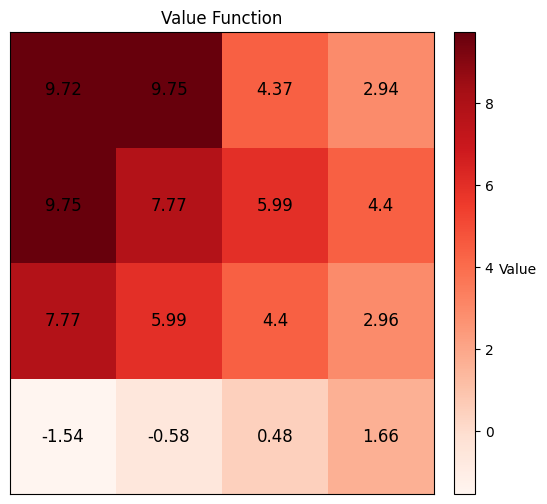

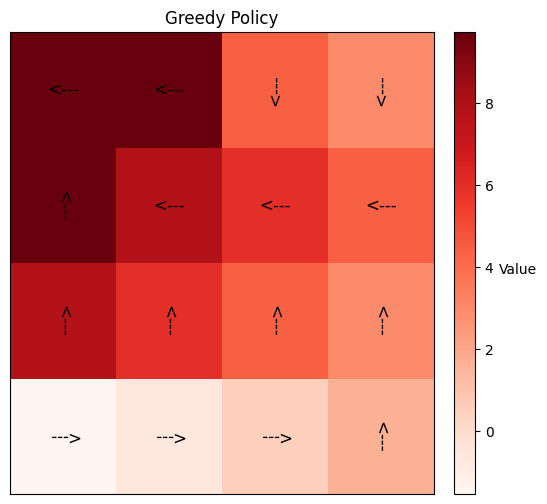

In [12]:
# Using the original rewards distribution
policy_iteration(dis_factor, theta, max_iters)

# Part A

# Question 1


Policy Iteration  | Iteration = 1
Policy Evaluation | #Sweeps = 7
Policy Improvement

Policy Iteration  | Iteration = 2
Policy Evaluation | #Sweeps = 7
Policy Improvement

Policy Iteration  | Iteration = 3
Policy Evaluation | #Sweeps = 3
Policy Improvement

Policy Iteration  | Iteration = 4
Policy Evaluation | #Sweeps = 2
Policy Improvement


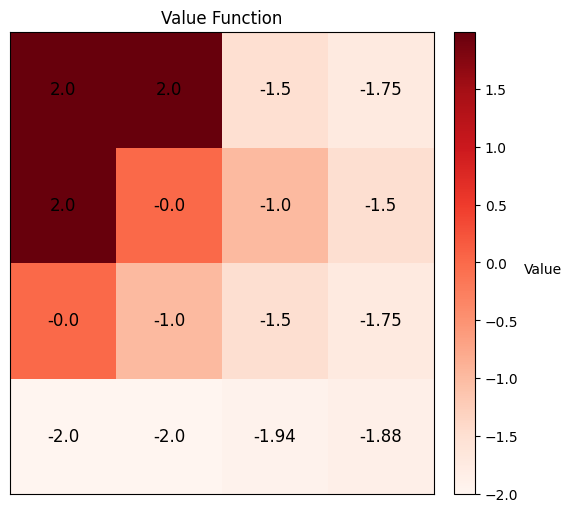

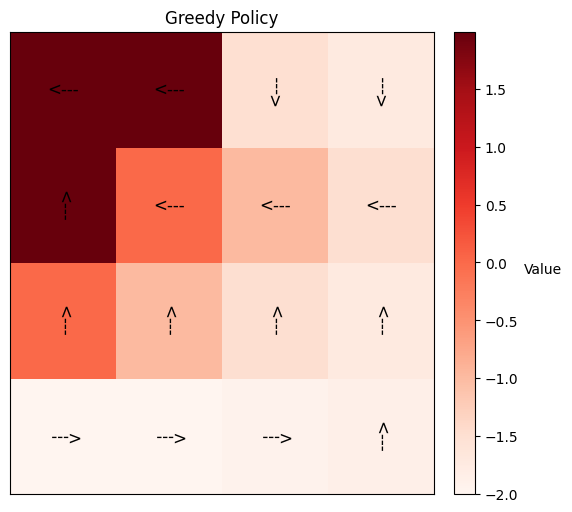

In [7]:
# Discount Factor
dis_factor_1 = 0.5
# Using the original rewards distribution
policy_iteration(dis_factor_1, theta, max_iters)


Policy Iteration  | Iteration = 1
Policy Evaluation | #Sweeps = 266
Policy Improvement

Policy Iteration  | Iteration = 2
Policy Evaluation | #Sweeps = 394
Policy Improvement

Policy Iteration  | Iteration = 3
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 4
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 5
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 6
Policy Evaluation | #Sweeps = 2
Policy Improvement


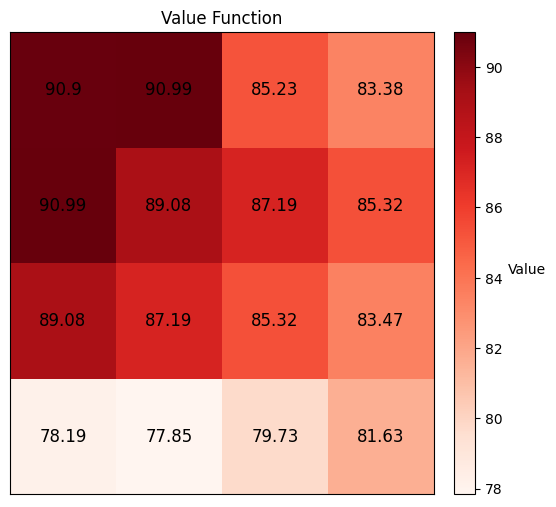

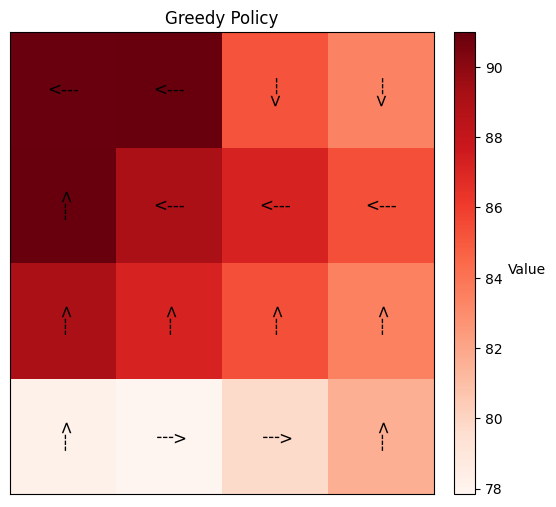

In [8]:
# Discount Factor
dis_factor_1 = 0.99
# Using the original rewards distribution
policy_iteration(dis_factor_1, theta, max_iters)

In [15]:
#updated rewards
update_rewards = [
                [+1, -10, -10, -10],
                [-3, -1, -1, -1],
                [-10, -10, -10, -1],
                [-1, -1, -1, -1],
            ]


Policy Iteration  | Iteration = 1
Policy Evaluation | #Sweeps = 267
Policy Improvement

Policy Iteration  | Iteration = 2
Policy Evaluation | #Sweeps = 397
Policy Improvement

Policy Iteration  | Iteration = 3
Policy Evaluation | #Sweeps = 3
Policy Improvement

Policy Iteration  | Iteration = 4
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 5
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 6
Policy Evaluation | #Sweeps = 2
Policy Improvement


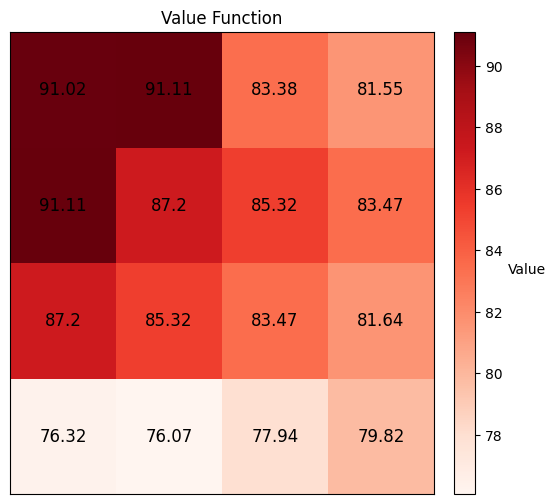

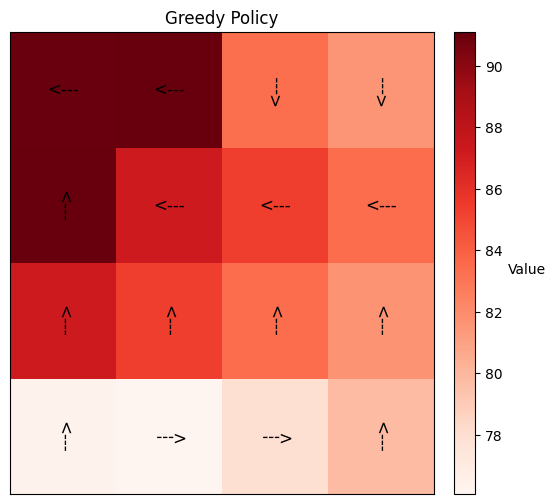

In [16]:
#policy iteration for reward at (1,0) =  -3
policy_iteration(0.99, theta, max_iters,update_rewards)

In [12]:
update_rewards_1 = [
                [+1, -10, -10, -10],
                [-5, -1, -1, -1],
                [-10, -10, -10, -1],
                [-1, -1, -1, -1],
            ]


Policy Iteration  | Iteration = 1
Policy Evaluation | #Sweeps = 29
Policy Improvement

Policy Iteration  | Iteration = 2
Policy Evaluation | #Sweeps = 39
Policy Improvement

Policy Iteration  | Iteration = 3
Policy Evaluation | #Sweeps = 3
Policy Improvement

Policy Iteration  | Iteration = 4
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 5
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 6
Policy Evaluation | #Sweeps = 2
Policy Improvement

Policy Iteration  | Iteration = 7
Policy Evaluation | #Sweeps = 2
Policy Improvement


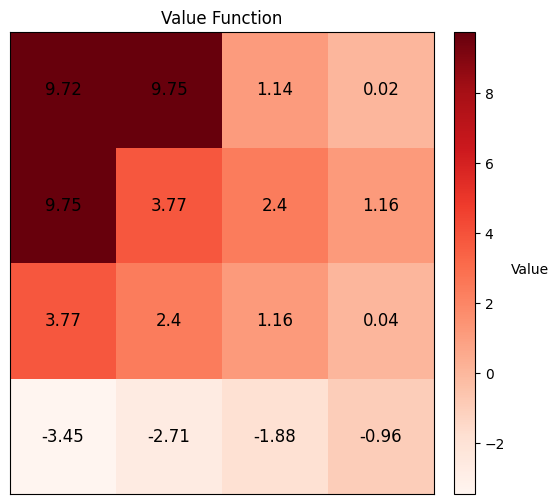

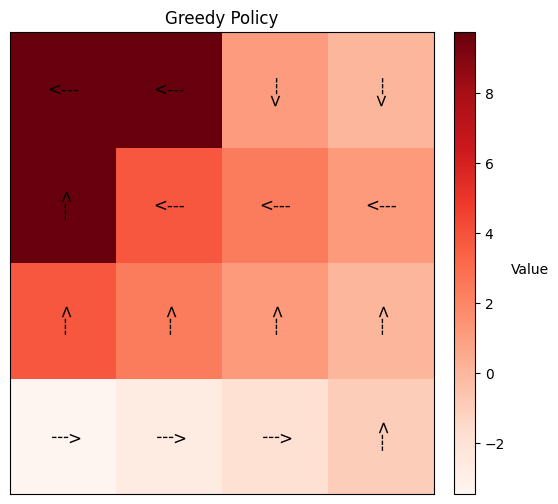

In [13]:
#policy iteration for reward at (1,0) =  -3
policy_iteration(dis_factor, theta, max_iters,update_rewards_1)

In [11]:
pi = np.ones((4,2)) * 0.5
print(pi)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]
